In [1139]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def draw_lines(img, lines, color=(0,0,255), thickness=3):
    im = img.copy()
    for line in lines:
        if np.any(line < 0):
            continue
        l = line.astype(np.uint64)
        im = cv2.line(im, l[0:2], l[2:4], color=color, thickness=thickness)
    return im

def center_of_image(img):
    return np.array(img.shape[:2][::-1])/2
    
def rotate_img(img: np.ndarray, angle: float, specific_point = None) -> np.ndarray:
    """
    Copied from user Jean-Christophe at https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
    """
    if specific_point is None:
        specific_point = center_of_image(img)
    warp_mat = np.zeros((2,3))
    cos, sin = np.cos(angle), np.sin(angle)
    warp_mat[:2,:2] = [[cos, -sin],[sin, cos]]
    warp_mat[:2,2] = specific_point - np.matmul(warp_mat[:2,:2], specific_point)
    return cv2.warpAffine(img, warp_mat, img.shape[:2][::-1])

def rotate_lines(lines, angle, center):
    """
    lines_rot = rotate_lines(lines, -avg_angle, center_of_image(img))
    """
    p0 = lines[:, 0:2]
    p1 = lines[:, 2:4]
    c, s = np.cos(angle), np.sin(angle)
    rot_transposed = np.array([[c, s], [-s, c]])
    p0_prime = ((p0 - center) @ rot_transposed) + center
    p1_prime = ((p1 - center) @ rot_transposed) + center
    return np.hstack((p0_prime, p1_prime))

def crop_to_square(img):
    center = center_of_image(img)
    height, width = img.shape[:2]
    length = min(width, height)
    return img[
        int(center[1] - length//2) : int(center[1] + length//2),
        int(center[0] - length//2) : int(center[0] + length//2)]

def posterize(img, n):
    """
    Copied from Pierre Debaisieux at
    https://stackoverflow.com/questions/11064454/adobe-photoshop-style-posterization-and-opencv
    """
    im = img.copy()
    for i in range(n):
        im[(im >= i * 255 / n) & (im < (i + 1) * 255 / n)] = i * 255 / (n - 1)
    return im

ENABLE_INPAINTING = True # disable for "lab" images with completely white backgrounds
ENABLE_FILTERING = False
SHOW_RECTANGLES = True
RECTANGLE_WIDTH = 20

## Getting the image
We start off by reading in the image.

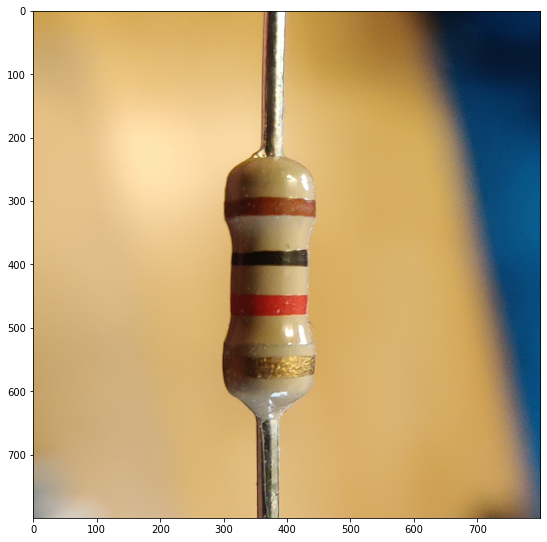

In [1140]:
# r0 works
# r1 does not work - 2/4
# r2 works
# r3 works
# r4_1 has problems with shadow
# r5 fails - detects too many edges in background
# r6 works
# r7 repairs in wrong direction
# r8 works
# r9 does not work
# r10 gets 2/4 right. Removes correct gold lines because of insufficient contrast
# r11 bad rotation and removes gold lines
# r12 workes
# r12_1 works
# r13 ambient component legs confuse the normalization
# r14 same as r13
IMPATH = "./img/r12.jpg"
img = cv2.imread(IMPATH)
if img is None:
    print(f"Failed to read file: {IMPATH}")
    exit()
# crop to square
img = crop_to_square(img)
# img_bw = crop_to_square(cv2.imread(IMPATH, cv2.IMREAD_GRAYSCALE))

# we don't need all that much detail - so we just scale down to get rid of some noise
new_width_height = (800, 800)
img = cv2.resize(img, new_width_height, interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
imshow(img)

## Preprocessing
After reading in the image we want to do some preprocessing to get rid of some artifacts.

### Highlight-Removal
One big pain-point are extreme highlights in the image (e.g. reflections in the paint). To get rid of them we convert our image into the Lab colour space and do a binary thresholding on the brightness channel to get a mask. We then use this mask for inpainting.

### Shadow Removal
Shadows create edges which can confuse the edge detection section - so we try to remove them at least a bit by doing basically the exact same thing as in the highlight removal.

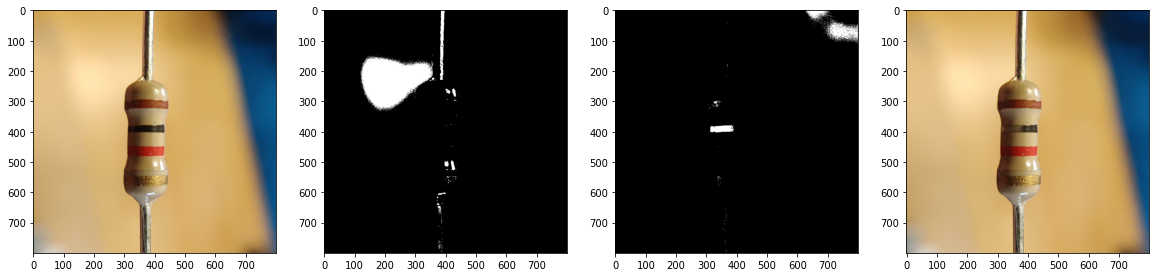

In [1141]:
# inpainting
if ENABLE_INPAINTING:
    im2 = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    imshow(img)
    mask = im2[:, :, 0]
    # TODO: tweak threshold a bit
    _, mask2_1 = cv2.threshold(mask, 220, 255, cv2.THRESH_BINARY) # Highlight mask
    _, mask2_2 = cv2.threshold(mask, 25, 255, cv2.THRESH_BINARY_INV) # Shadow mask
    plt.subplot(1,4,2)
    imshow(mask2_1)
    plt.subplot(1,4,3)
    imshow(mask2_2)
    mask3_1 = cv2.cvtColor(mask2_2, cv2.COLOR_GRAY2BGR)
    mask3_2 = cv2.cvtColor(mask2_2, cv2.COLOR_GRAY2BGR)
    mask3 = np.logical_or(mask3_1, mask3_2)
    im3 = np.bitwise_and(mask3, img)
    im4 = cv2.inpaint(img, mask2_2, 20, cv2.INPAINT_TELEA)
    #img = cv2.cvtColor(im3, cv2.COLOR_LAB2BGR)
    plt.subplot(1,4,4)
    imshow(im4)
    img = im4

img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Filtering
Before starting with the actual "solution" part, we'll apply some filters. To further smoothen out artifacts we'll apply a small blur filter and to aid in edge detection we'll apply a edge detection filter.

In [1142]:
if ENABLE_FILTERING:
    # kernels from https://en.wikipedia.org/wiki/Kernel_(image_processing)
    box_blur = np.ones((3,3))/9
    edge_detection_1 = np.matrix([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
    edge_detection_2 = 4*np.matrix([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    edge_detection_3 = np.matrix([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    img = cv2.filter2D(img, -1, box_blur)
    img_bw = cv2.filter2D(img_bw, -1, edge_detection_3)
    img_bw = cv2.filter2D(img_bw, -1, box_blur)

## Image normalization
The image normalization relies on the fact that the resistors have "straight" wires sticking out on either side that are in line with the resistor body. We want to detect those lines and orient them such that they make an 0° angle with the horizontal axis. The algorithm proceeds as follows:
* compute the angles of all lines modulo π. The modulo is taken because we don't care about the orientation of our lines
* "cluster" the angles into three groups based on this angle. The groups should ideally work out something like:
  * the lines coaxial with the resistor wires
  * the lines at an 90° angle to the first group
  * a group for the remaining noise
* find the largest group. We assume that this is the first group
* compute the average angle of that group and rotate the image such that this angle is now 0°


So we start off with detecting all the "long" lines in the image using openCVs fast line detector.

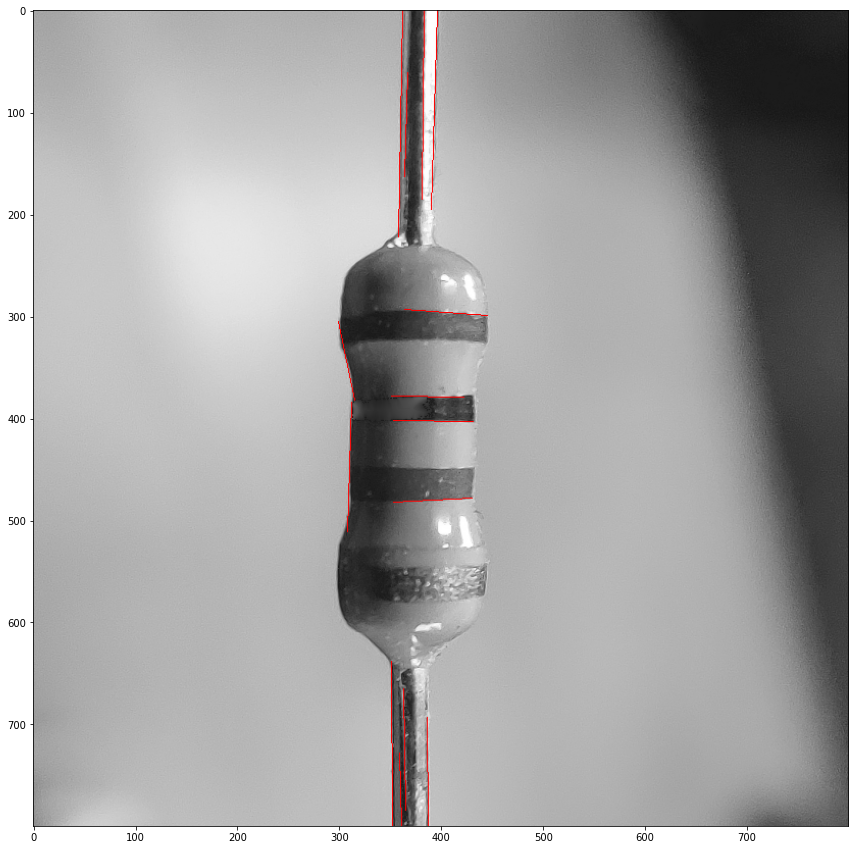

In [1143]:
fld = cv2.ximgproc.createFastLineDetector(length_threshold=70, distance_threshold=3) # canny_th1=50, canny_aperture_size=3
lines = fld.detect(img_bw)
img_with_lines = fld.drawSegments(img_bw, lines)
lines = lines[:, 0, :] # remove unneeded dimension
# print(lines)
plt.figure(figsize=(15,15))
imshow(img_with_lines)

## Normalization
We now want to normalize the image in such a way that the resistor is laying "sideways". To do this we proceed as follows:
* compute the angles of all lines modulo π. The modulo is taken because we don't care about the orientation of our lines
* "cluster" the angles into three groups based on this angle. The groups should ideally work out something like:
  * the lines coaxial with the resistor wires
  * the lines at an 90° angle to the first group
  * a group for the remaining noise
* find the largest group. We assume that this is the first group
* compute the average angle of that group and rotate the image such that this angle is now 0°

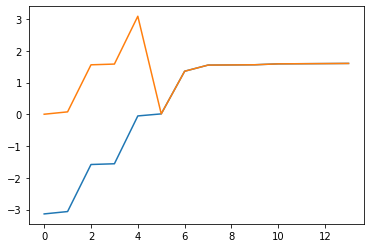

In [1144]:
def calculate_angles(lines):
    x0 = lines[:, 0]
    y0 = lines[:, 1]
    x1 = lines[:, 2]
    y1 = lines[:, 3]
    return np.arctan2(y0 - y1, x0 - x1)
    
angles = calculate_angles(lines)
indices = np.arange(len(angles))
#np.argsort(angles)
line_angles = np.vstack((indices, angles))
line_angles.sort(axis=1)
line_angles[:, 1]
plt.plot(line_angles[0, :], line_angles[1, :])
plt.plot(line_angles[0, :], np.mod(line_angles[1, :], np.pi))
#
#clustering = KMeans(n_clusters=3)
#clustering.fit()

[  0.2115856  59.185383  118.15919   177.133    ]


89.19679274865217

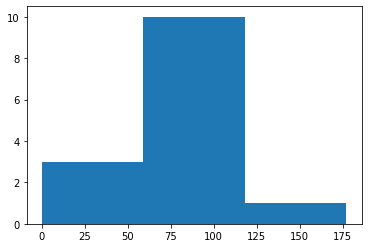

In [1145]:
# we don't care about the direction of our lines
# so we take the remainder after division by π
angles_for_hist = np.mod(angles, np.pi)
counts, borders = np.histogram(angles_for_hist, bins=3)
plt.hist(angles_for_hist*180/np.pi, bins=3)
print(borders*180/np.pi)
index_of_max = np.argmax(counts)
border_of_max = borders[index_of_max:index_of_max+2] # most angles lie in this bracket
# compute the average of all the angles that fall into the "most common angles" bracket
avg_angle = np.mean(angles_for_hist[np.logical_and(border_of_max[0] <= angles_for_hist, angles_for_hist <= border_of_max[1])])
avg_angle * 180/np.pi

## Decting approximate strip borders
After finding the angle of the body / wires we rotate the whole picture by it. We then detect lines again, allowing shorter ones this time around. From those short lines we filter all of those out that are not at an approximately 90° (mod π) to the horizontal axis. These should correspond to the borders of the coloured strips.

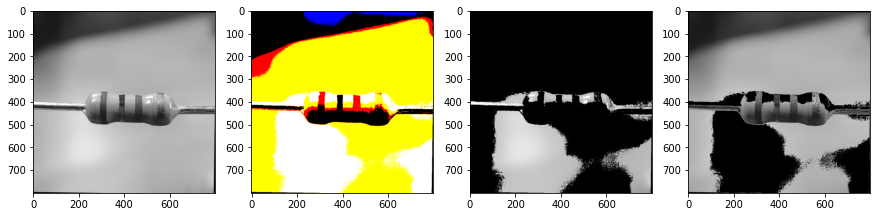

In [1146]:
rotation_angle = -avg_angle
img_bw_rot = rotate_img(img_bw, rotation_angle)
img_rot = rotate_img(img, rotation_angle)

# we posterize the image to find the "colourful" areas
# we then use this as a mask for our black and white image
# so that the less colourful sections of the image
# don't fuck with the line detection. Note the way better contrast
# in the image below in contrast (...) to the original bw image.

plt.figure(figsize=(15,15))
plt.subplot(1,4,1)
imshow(img_bw_rot)
post = posterize(img_rot, 2)
plt.subplot(1,4,2)
imshow(post)
img_bw_rot_1 = img_bw_rot.copy()
img_bw_rot_2 = img_bw_rot.copy()
img_bw_rot_1[np.any(post < 20, axis=2)] = 0
img_bw_rot_2[np.all(post > 20, axis=2)] = 0
plt.subplot(1,4,3)
imshow(img_bw_rot_1)
plt.subplot(1,4,4)
imshow(img_bw_rot_2)

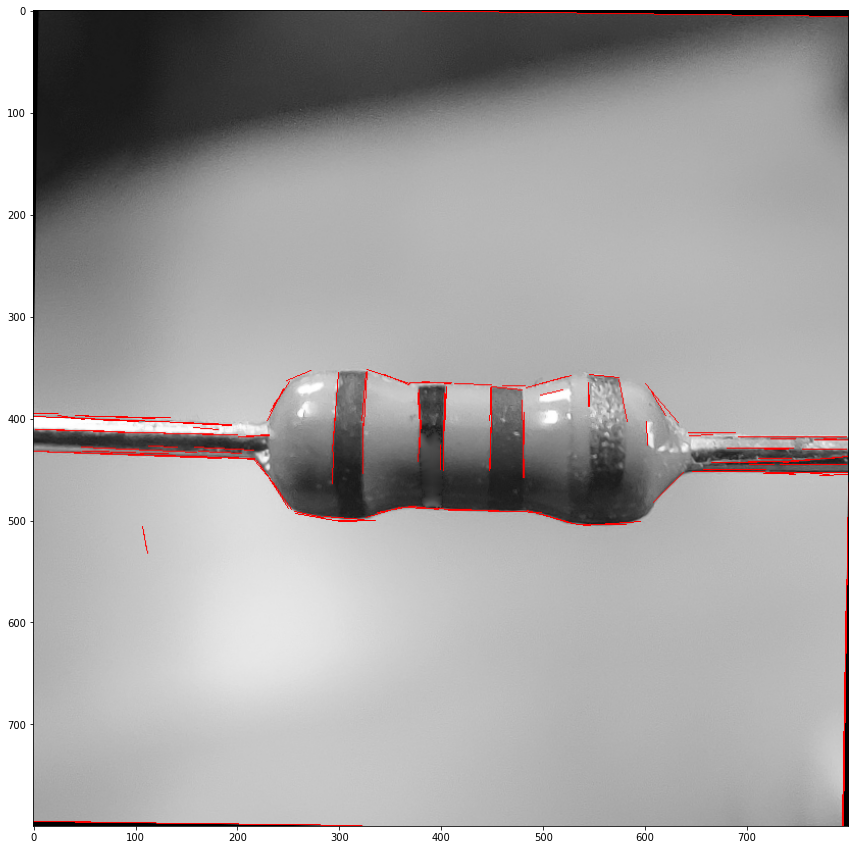

In [1147]:
fld = cv2.ximgproc.createFastLineDetector(length_threshold=22)
# TODO: preprocess image to improve line detection
lines = np.vstack((
    fld.detect(img_bw_rot), # unmodified image
    fld.detect(img_bw_rot_1), # posterized "in one direction"
    fld.detect(img_bw_rot_2))) # posterized "in other direction"
img_with_lines = fld.drawSegments(img_bw_rot, lines)
lines = lines[:, 0, :] # remove unneeded dimension
plt.figure(figsize=(15,15))
imshow(img_with_lines)

In [1148]:
# we only consider lines that are approximately vertical
lines = lines[np.abs(np.mod(calculate_angles(lines), np.pi) - np.pi/2) < 0.2] # 0.2 rad are approximately 10°
line_centers = (lines[:, :2] + lines[:, 2:])/2

# We restrict ourselves to the 1-norm ball of radius (image width)/2 = image width / 2 to eliminate the
# lines that may be created by the rotation. Note that we could also just don't do any rotation at all and
# instead compare our angles relative to the computed rotation angle - but meh. So we remove all lines whose
# centerpoint is outside of the aforementioned ball.
center = center_of_image(img_bw_rot)
distance_vectors_image_center = np.abs(line_centers - center)
height, width = img_bw_rot.shape[:2]
mask_1 = np.linalg.norm(distance_vectors_image_center, 1, axis=1) <= (width / 2)

# Remove upper and lower sections of the image. We assume that the image is in the middle section
# TODO: this may need some tweaking (e.g. only consider middle two fourths or something).
# mask_1 = np.logical_and(mask_1, distance_vectors_image_center[:, 1] <= 4/5 * height)
# mask_1 = np.logical_and(mask_1, distance_vectors_image_center[:, 1] >= 1/5 * height)

lines = lines[mask_1]

# We check where most of the remaining lines are and compute their "center of mass". Then we assume that all
# the correct lines are approximately around this point and remove the rest.
line_centers = (lines[:, :2] + lines[:, 2:])/2
deltas = lines[:, [0,1]] - lines[:, [2,3]]
line_lengths = np.linalg.norm(deltas, axis=1)
weights = line_lengths / np.sum(line_lengths)
# we weight each line by each lengths and then take something like the mean
lines_com =  weights @ line_centers # np.median(line_centers, axis=0)
# print(lines_com)

center_stdev = np.std(line_centers, axis=0)
is_in_cluster = np.abs(line_centers - lines_com) <= 3 * center_stdev
mask = np.all(is_in_cluster, axis=1)
lines = lines[mask]
line_lengths = line_lengths[mask]

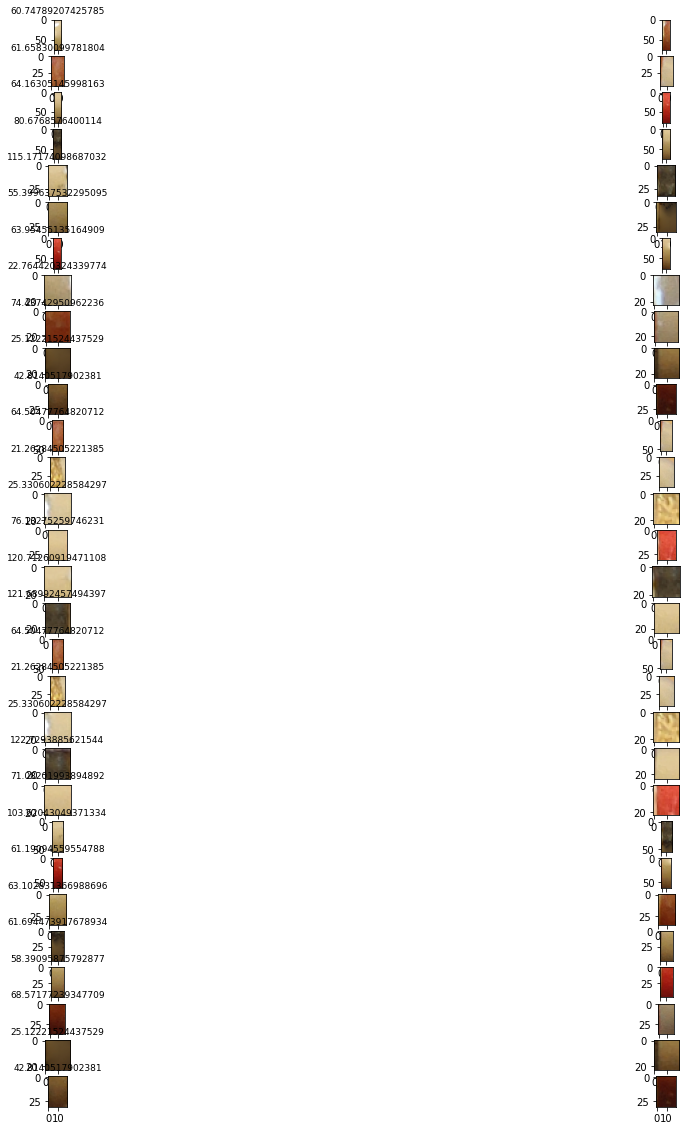

In [1149]:

# furthermore we reject all lines for which the colors on either side don't differ to some extent
mask = lines[:, [1,3]].argsort(axis=1) == 1 # find the lower y coordinate index for each line
lower_points = np.vstack((lines[:, [0,2]][mask], lines[:, [1,3]][mask])).T.astype(np.uint32)
upper_points = lower_points.copy()
# calculate line lengths of remaining lines
deltas = lines[:, [0,1]] - lines[:, [2,3]]
line_lengths = np.linalg.norm(deltas, axis=1)
upper_points[:, 1] -= line_lengths.astype(np.uint32) # we assume perfectly straight lines
# upper_points = upper_points[upper_points[:, 1] <= height, :]
lul = upper_points[:, :] - np.array((RECTANGLE_WIDTH, 0)) # left side; upper left
lbr = lower_points[:, :] # left side; bottom right
rul = upper_points[:, :] # right side; upper left
rbr = lower_points[:, :] + np.array((RECTANGLE_WIDTH, 0)) # right side; bottom right
plt.figure(figsize=(20, 20))
mask = np.ones(lines.shape[0], dtype=np.bool8)
img_rot_lab = cv2.cvtColor(img_rot, cv2.COLOR_BGR2Lab)
for i in range(lines.shape[0]): # for each line
    left_side = img_rot_lab[lul[i, 1] : lbr[i, 1], lul[i, 0] : lbr[i, 0]]
    right_side = img_rot_lab[rul[i, 1] : rbr[i, 1], rul[i, 0] : rbr[i, 0]]
    dist = np.linalg.norm(np.mean(left_side, axis=(0,1)) - np.mean(right_side, axis=(0,1)))
    if dist < 25:
        mask[i] = False
    plt.subplot(lines.shape[0], 2, 2*i+1)
    plt.title(str(dist), fontdict={"size": 9})
    imshow(cv2.cvtColor(left_side, cv2.COLOR_LAB2BGR))
    plt.subplot(lines.shape[0], 2, 2*i+2)
    imshow(cv2.cvtColor(right_side, cv2.COLOR_LAB2BGR))
lines = lines[mask]

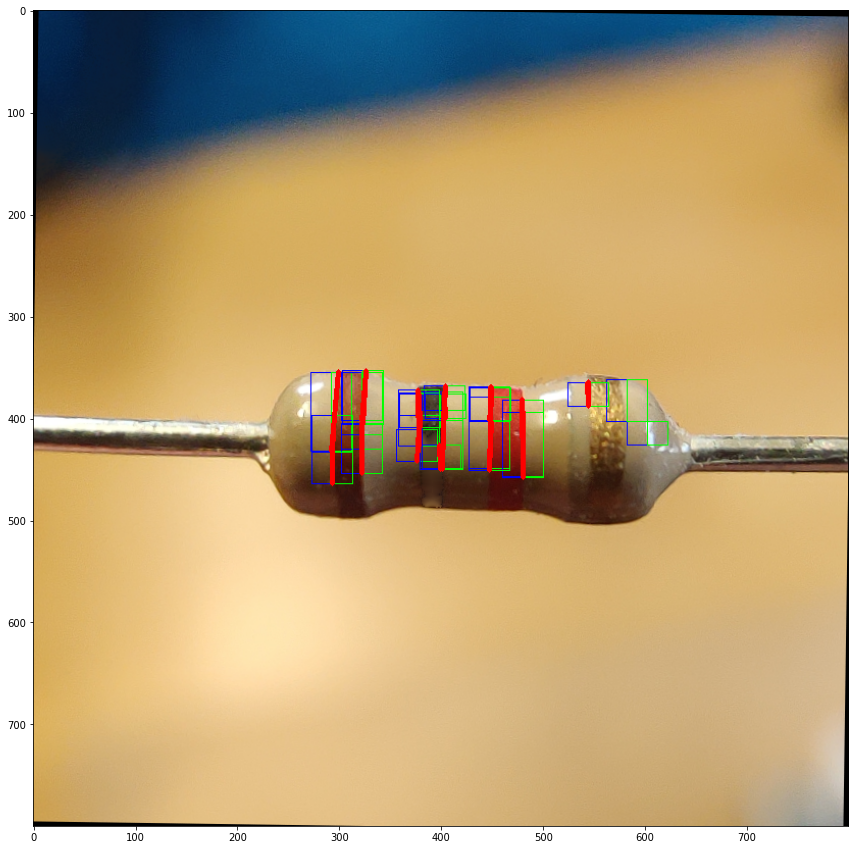

In [1150]:
plt.figure(figsize=(15,15))
if SHOW_RECTANGLES:
    img_with_rects = img_rot.copy()
    plt.subplot()
    for i in range(upper_points.shape[0]):
        img_with_rects = cv2.rectangle(img_with_rects, lul[i, :], lbr[i, :], (255, 0, 0))
        img_with_rects = cv2.rectangle(img_with_rects, rul[i, :], rbr[i, :], (0, 255, 0))
    imshow(draw_lines(img_with_rects, lines))
else:
    imshow(draw_lines(img_rot, lines))

### Detecting that we're missing lines
We now want to check the differences between our line clusters. We begin by sorting all lines according to their x coordinates and then consider the 7 biggest gaps between the lines - these 7 gaps correspond to the four colorstrips and the three spaces between them.

In [1151]:
xs = lines[:, 0]
lines = lines[xs.argsort()]
xs = xs[xs.argsort()]
differences = np.diff(xs)
sort_differences = np.argsort(differences)
biggest_differences = differences[sort_differences[-7:]]
biggest_differences[np.abs(biggest_differences - np.mean(biggest_differences)) >= 2 * np.std(biggest_differences)]
# we now find all the distances (or their indices) that are in the "big distances" group but are considerably smaller
# than the mean of that group.
mask = np.mean(biggest_differences) - biggest_differences >= 25 # 1.5*np.std(biggest_differences)
potential_double_lines_idx = sort_differences[-7:][mask]
n_lines_missing = len(potential_double_lines_idx)
print("The biggest differences are: ", biggest_differences)
print("The differences ", differences[potential_double_lines_idx], " are too small")

The biggest differences are:  [ 2.8252869 19.520721  29.417969  29.986023  43.12033   49.81317
 63.07718  ]
The differences  [2.8252869]  are too small


## Refining Borders
Now that we've recognized the borders to some extent we want to use the information we've gathered to extend these borders in such a way that they enclose a portion of the strip that's as large as possible.

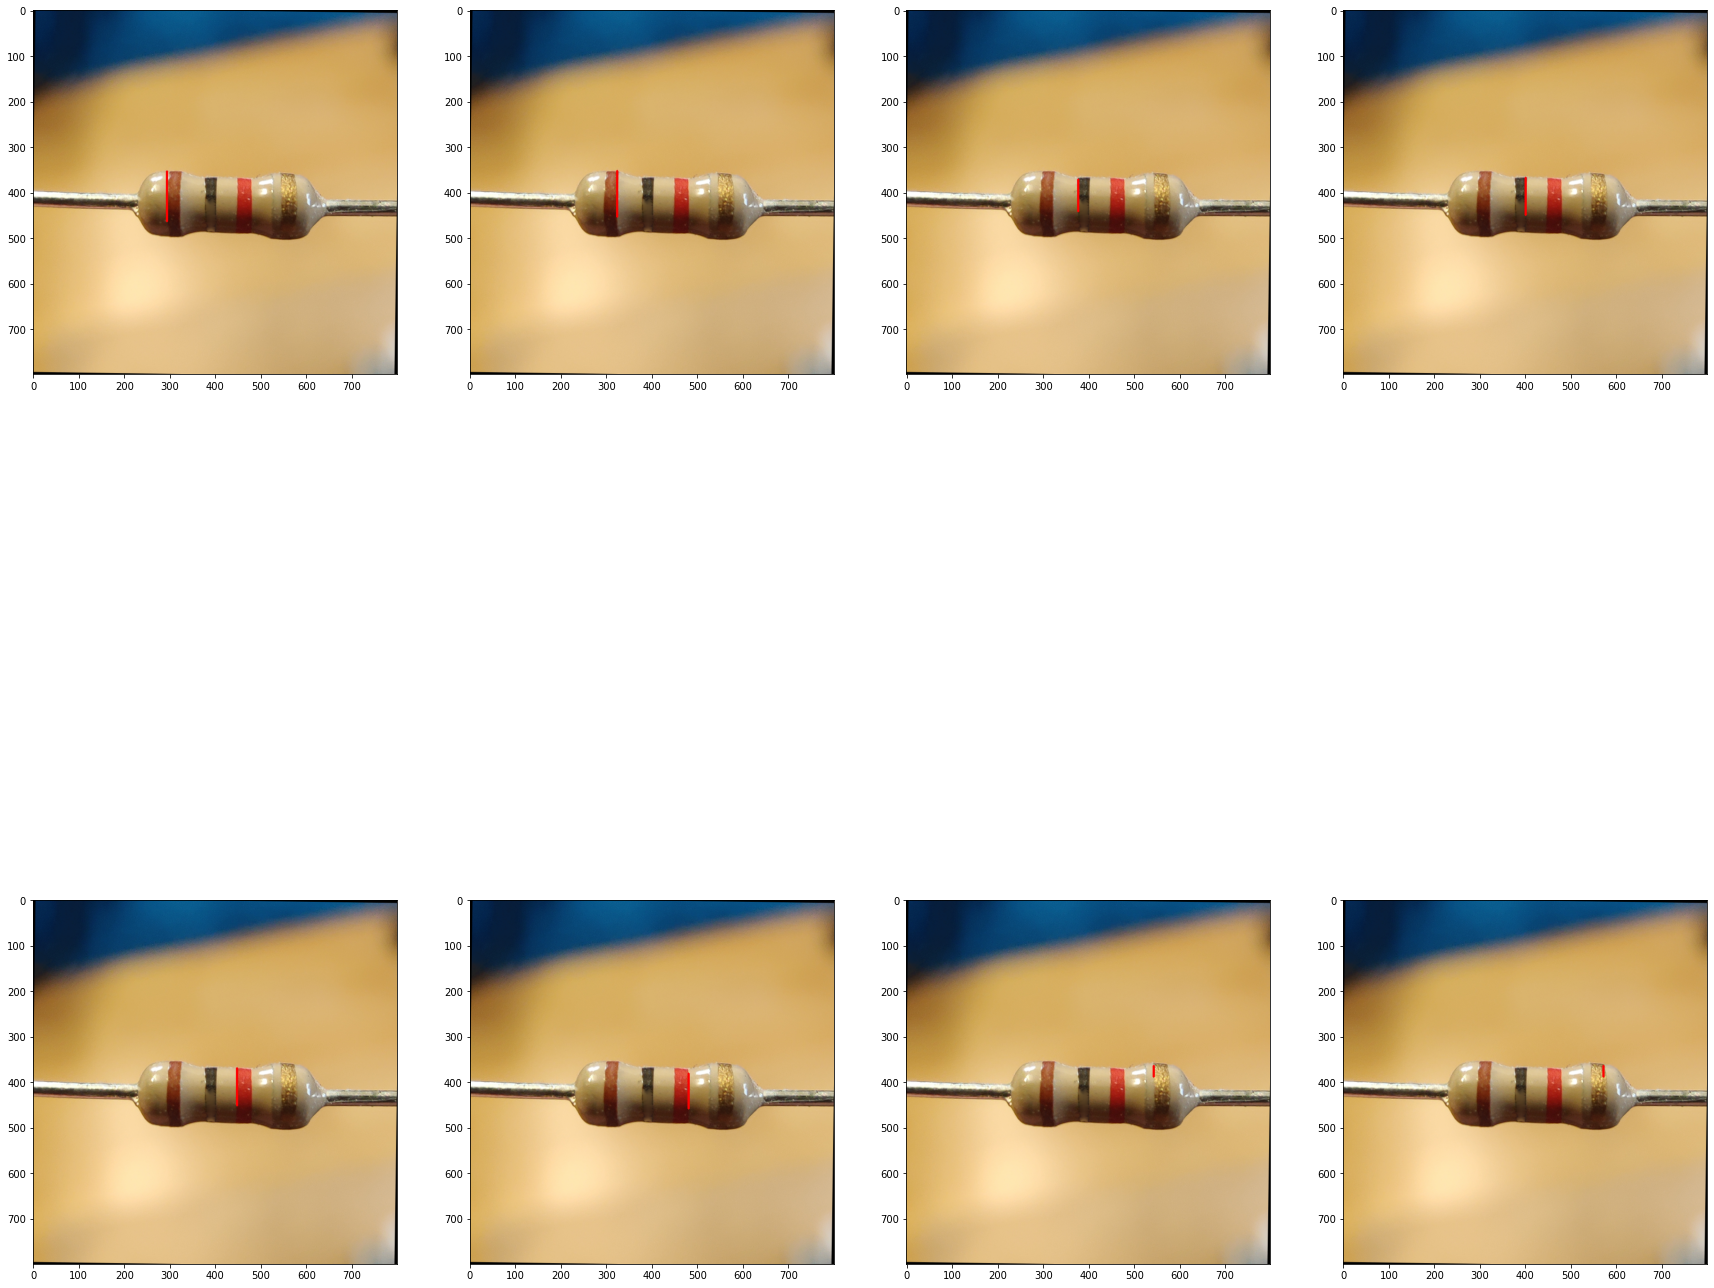

In [1152]:
def compute_cluster_edges(cluster, lines, sorted=True):
    """ Draw substitute lines for each cluster that are bounded by the extremal
    y-coordinates inside their cluster.
    """
    n_clusters = cluster.n_clusters
    strip_borders = np.zeros((n_clusters, 4))
    for i in range(n_clusters):
        lines_in_cluster = lines[cluster.labels_ == i]
        x_values = lines_in_cluster[:, [0, 2]]
        y_values = lines_in_cluster[:, [1, 3]]
        new_x = np.mean(x_values)
        new_top_y = np.amax(y_values.flatten())
        new_bottom_y = np.amin(y_values.flatten())
        strip_borders[i, :] = np.array([new_x, new_top_y, new_x, new_bottom_y])
    strip_borders = strip_borders[strip_borders[:, 0].argsort()]
    return strip_borders

if n_lines_missing > 0:
    # We now try to infer missing edges if we've noticed that some are probably missing. For now we'll assume,
    # that the missing lines are the one belonging to the gold/silver band at the very edge and will only add
    # a single edge.
    if n_lines_missing > 1:
        raise NotImplementedError("Edge inferrence only implemented for a single missing edge.")
    n_clusters = 7
    # TODO : don't recompute line centers - reuse from earlier
    cluster = KMeans(n_clusters=n_clusters).fit(np.mean(np.stack((lines[:, 0], lines[:, 2])), axis=0).reshape(-1, 1))
    strip_borders = compute_cluster_edges(cluster, lines, sorted=True)
    # compute the average strip width
    differences = np.diff(strip_borders[:, 0])
    cluster_2 = KMeans(n_clusters=2).fit(differences.reshape(-1, 1))
    m_0 = np.mean(differences[cluster_2.labels_ == 0])
    m_1 = np.mean(differences[cluster_2.labels_ == 1])
    if m_0 < m_1:
        small_cluster = 0
        big_cluster = 1
    else:
        small_cluster = 1
        big_cluster = 0
    line_width = min(m_0, m_1)
    # find out if we want to add our strip on the left or right side
    # to do this we consider the gap sizes on either side - small gaps
    # are strips.
    # FIX: don't use in because it compares floats for equality which isn't nice but
    # should work in this case.
    if (differences[0] in differences[cluster_2.labels_ == small_cluster] and
        differences[-1] in differences[cluster_2.labels_ == big_cluster]):
        insert_line_at_idx = -1
        shift = 1 # if we insert right we want to shift the line right
    else: # TODO: we should probably do another check here in case both sides are small / big strips
        insert_line_at_idx = 0
        shift = -1 # if we insert left we want to shift the line left
    new_line = strip_borders[insert_line_at_idx, :].copy()
    new_line[[0, 2]] += shift * line_width
    new_lines = np.ones((strip_borders.shape[0] + 1, 4))
    new_lines[insert_line_at_idx, :] = new_line
    new_lines[insert_line_at_idx + 1 : insert_line_at_idx + 8, :] = strip_borders
    strip_borders = new_lines

    plt.figure(figsize=(30, 30))
    for i in range(8):
        plt.subplot(2, 4,i+1)
        imshow(draw_lines(img_rot, [strip_borders[i, :]]))
else:
    # We now group all the lines together that have approximately the same x coordinates
    # since we expect at least two lines per colored strip we set n_clusters to 2⋅4=8.
    n_clusters = 8
    cluster = KMeans(n_clusters=n_clusters).fit(np.mean(np.stack((lines[:, 0], lines[:, 2])), axis=0).reshape(-1, 1))
    strip_borders = compute_cluster_edges(cluster, lines)
    plt.figure(figsize=(30, 30))
    for i in range(n_clusters):
        plt.subplot(2, 4,i+1)
        imshow(draw_lines(img_rot, lines[cluster.labels_==i]))

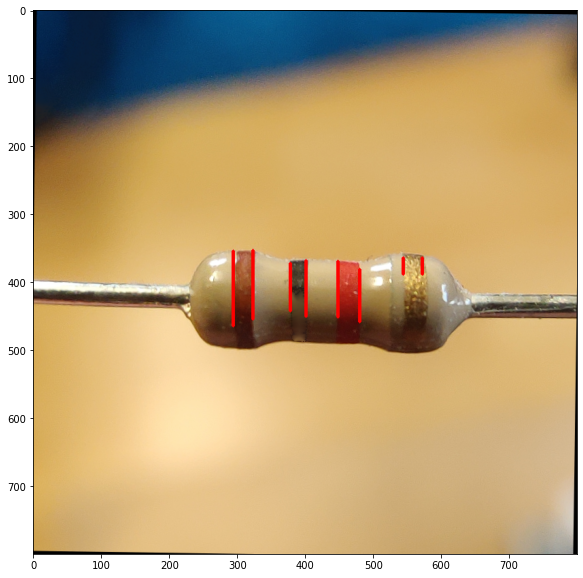

In [1153]:


plt.figure(figsize=(10,10))
imshow(draw_lines(img_rot, strip_borders))
# and proceed to sort the lines from left to right by sorting according to the
# x-coordinate of each line
strip_borders = strip_borders[np.argsort(strip_borders[:, 0])]

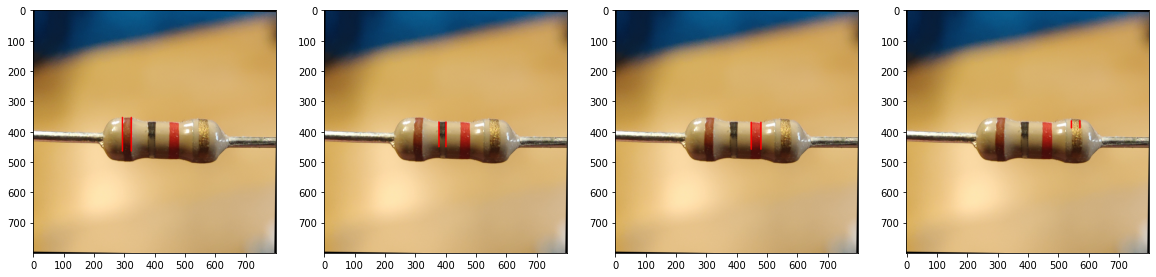

In [1154]:

# for each strip we now want to find a rectangle that covers as much of the strip as possible.
# To do this we modify the y-coordinates such that they extend as far up/down on either side of the strip.
# print(strip_borders)
big_y_pairs = np.vstack((strip_borders[0::2, 1], strip_borders[1::2, 1]))
small_y_pairs = np.vstack((strip_borders[0::2, 3], strip_borders[1::2, 3]))
strip_borders[0::2, 1] = np.amax(big_y_pairs, axis=0)
strip_borders[1::2, 1] = np.amax(big_y_pairs, axis=0)
strip_borders[0::2, 3] = np.min(small_y_pairs, axis=0)
strip_borders[1::2, 3] = np.min(small_y_pairs, axis=0)
# the border line-pairs are now of the form
# ((point bottom left, point top left),
#  (point bottom right, point top right))
# print(strip_borders)
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(1,4,i+1)
    imshow(draw_lines(img_rot, strip_borders[2*i:2*i+2, :]))


Average color on strip 0:  [ 42.12084498  70.60702081 131.15439578]
Average color on strip 1:  [40.38282078 62.92364793 79.53711559]
Average color on strip 2:  [ 37.78967697  53.61235955 171.90976124]
Average color on strip 3:  [107.13095238 173.31696429 206.71130952]


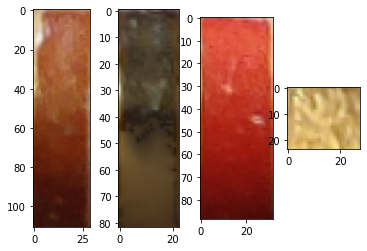

In [1155]:
x_indices = np.arange(img.shape[0])
y_indices = np.arange(img.shape[1])
# print(strip_borders[0::2, 0])
# print(x_indices)
strip_colors = []
for i in range(4): # for each strip
    bottom_left = strip_borders[2*i, :2]
    top_right = strip_borders[2*i+1, 2:] # since y-axis is down y(top) < y(bottom) 
    x_mask = np.logical_and(bottom_left[0] <= x_indices, x_indices <= top_right[0])
    y_mask = np.logical_and(top_right[1] <= y_indices, y_indices <= bottom_left[1])
    plt.subplot(1, 4, i+1)
    imshow(img_rot[:, x_mask][y_mask, :])
    color_avg = np.mean(img_rot[:, x_mask][y_mask, :], axis=(0,1))
    print(f"Average color on strip {i}: ", color_avg)
    strip_colors.append(color_avg)

## Finding right name for color
We now want to convert each of the colours into a linear perceptual color space, such that the euclidean distance corresponds to how a human might compare colours. Then we'll match distances from a dictionary of reference colours to get the right name for the color.

In [1156]:
RESISTOR_COLORS = np.uint8([ # IEC 60757 colors in 8-bit RGB
    [14, 14, 16],
    [126, 75, 38],
    [167, 41, 32],
    [246, 120, 40],
    [246, 182, 0],
    [97, 153, 59],
    [0, 124, 176],
    [118, 104, 154],
    [122, 136, 142],
    [227, 217, 198],
    # pink and turquoise aren't used for resistors
    # [216, 160, 166],
    # [126, 186, 181],
    # gold and silver don't have standardized colours
    # so I just eyeballed them / took them from the "measurements"
    [113, 93, 60],
    [178, 178, 178]
    ])
# open-cv uses BGR so we switch the R and B columns
# before converting to Lab.
RESISTOR_COLORS_LAB = cv2.cvtColor(np.uint8([RESISTOR_COLORS[:, [2, 1, 0]]]), cv2.COLOR_BGR2LAB)[0]
COLOR_NAMES = (
    "black",
    "brown",
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "violet",
    "grey",
    "white",
    #"pink",
    #"turquoise",
    "gold",
    "silver")
for i, color in enumerate(strip_colors):
    lab_color = cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_BGR2LAB)[0][0]
    #print(np.abs(np.float64(RESISTOR_COLORS_LAB) - np.float64(lab_color)))
    distances = np.linalg.norm(np.abs(np.float64(RESISTOR_COLORS_LAB) - np.float64(lab_color)), axis=1)
    best_fit_idx = np.argmin(distances)
    print(f"The best fit for strip {i} is {COLOR_NAMES[best_fit_idx]}")


The best fit for strip 0 is brown
The best fit for strip 1 is brown
The best fit for strip 2 is red
The best fit for strip 3 is silver
